<a href="https://colab.research.google.com/github/jadapache/CovidSantander/blob/master/Covid_Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing packages
import numpy as np
from scipy.integrate import odeint
from scipy import stats
from urllib.request import urlopen
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import requests
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
!pip install plotly --upgrade  #Se reinstala Ploty por error choropleth() got an unexpected keyword argument 'geojson'

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [ ]:
#Import DataSet
cifras = pd.read_csv('https://raw.githubusercontent.com/jadapache/CovidSantander/master/Casos_positivos_de_COVID-19_en_Santander.csv')
cifras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93077 entries, 0 to 93076
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   fecha reporte web             93077 non-null  object 
 1   ID de caso                    93077 non-null  int64  
 2   Fecha de notificación         93077 non-null  object 
 3   Código DIVIPOLA departamento  93077 non-null  int64  
 4   Nombre departamento           93077 non-null  object 
 5   Código DIVIPOLA municipio     93077 non-null  int64  
 6   Nombre municipio              93077 non-null  object 
 7   Edad                          93077 non-null  int64  
 8   Unidad de medida de edad      93077 non-null  int64  
 9   Sexo                          93077 non-null  object 
 10  Tipo de contagio              93077 non-null  object 
 11  Ubicación del caso            92720 non-null  object 
 12  Estado                        92720 non-null  object 
 13  C

In [ ]:
cifras.head()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,16/3/2020 0:00:00,60,14/3/2020 0:00:00,68,SANTANDER,68276,FLORIDABLANCA,24,1,M,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,12/3/2020 0:00:00,NaN,16/3/2020 0:00:00,31/3/2020 0:00:00,PCR,6.0,NaN
1,15/3/2020 0:00:00,89,14/3/2020 0:00:00,68,SANTANDER,68001,BUCARAMANGA,39,1,F,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,14/3/2020 0:00:00,NaN,15/3/2020 0:00:00,10/4/2020 0:00:00,PCR,6.0,NaN
2,19/3/2020 0:00:00,221,13/3/2020 0:00:00,68,SANTANDER,68001,BUCARAMANGA,49,1,F,Importado,Casa,Leve,214.0,REPÚBLICA DOMINICANA,Recuperado,12/3/2020 0:00:00,NaN,19/3/2020 0:00:00,27/3/2020 0:00:00,PCR,6.0,NaN
3,23/3/2020 0:00:00,451,23/3/2020 0:00:00,68,SANTANDER,68001,BUCARAMANGA,33,1,F,Importado,Casa,Leve,484.0,MÉXICO,Recuperado,13/3/2020 0:00:00,NaN,23/3/2020 0:00:00,6/4/2020 0:00:00,PCR,6.0,NaN
4,29/3/2020 0:00:00,685,24/3/2020 0:00:00,68,SANTANDER,68001,BUCARAMANGA,80,1,F,Importado,Casa,Leve,76.0,BRASIL,Recuperado,15/3/2020 0:00:00,NaN,29/3/2020 0:00:00,1/5/2020 0:00:00,PCR,6.0,NaN


In [ ]:
#Reformateamos the data
cifras.drop(['Fecha de notificación', 'Código ISO del país', 'Nombre departamento','Unidad de medida de edad','Código DIVIPOLA departamento'],axis=1,inplace=True)
cifras.rename(columns={'fecha reporte web':'FechaReporte', 'Nombre municipio':'Municipio', 'Fecha de inicio de síntomas':'FechaSintomas','Fecha de diagnóstico':'FechaDiagnostico','Fecha de recuperación':'FechaRecuperacion','Fecha de muerte':'FechaMuerte', 'Recuperado':'Casos', 'Código DIVIPOLA municipio':'id'} ,inplace=True)
cifras.head()

,FechaReporte,ID de caso,id,Municipio,Edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Nombre del país,Casos,FechaSintomas,FechaMuerte,FechaDiagnostico,FechaRecuperacion,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,16/3/2020 0:00:00,60,68276,FLORIDABLANCA,24,M,Importado,Casa,Leve,ESPAÑA,Recuperado,12/3/2020 0:00:00,NaN,16/3/2020 0:00:00,31/3/2020 0:00:00,PCR,6.0,NaN
1,15/3/2020 0:00:00,89,68001,BUCARAMANGA,39,F,Importado,Casa,Leve,ESPAÑA,Recuperado,14/3/2020 0:00:00,NaN,15/3/2020 0:00:00,10/4/2020 0:00:00,PCR,6.0,NaN
2,19/3/2020 0:00:00,221,68001,BUCARAMANGA,49,F,Importado,Casa,Leve,REPÚBLICA DOMINICANA,Recuperado,12/3/2020 0:00:00,NaN,19/3/2020 0:00:00,27/3/2020 0:00:00,PCR,6.0,NaN
3,23/3/2020 0:00:00,451,68001,BUCARAMANGA,33,F,Importado,Casa,Leve,MÉXICO,Recuperado,13/3/2020 0:00:00,NaN,23/3/2020 0:00:00,6/4/2020 0:00:00,PCR,6.0,NaN
4,29/3/2020 0:00:00,685,68001,BUCARAMANGA,80,F,Importado,Casa,Leve,BRASIL,Recuperado,15/3/2020 0:00:00,NaN,29/3/2020 0:00:00,1/5/2020 0:00:00,PCR,6.0,NaN


In [ ]:
#Counting registers
cifras["Municipio"].value_counts()

BUCARAMANGA        39706
BARRANCABERMEJA    14162
FLORIDABLANCA      13887
GIRON               6678
PIEDECUESTA         6474
                   ...  
PALMAR                 5
GALAN                  4
ENCINO                 3
JORDAN                 2
barrancabermeja        1
Name: Municipio, Length: 88, dtype: int64

In [ ]:
cifras['FechaReporte'] =  pd.to_datetime(cifras['FechaReporte'],  format='%d/%m/%Y %H:%M:%S')
cifras['FechaSintomas'] =  pd.to_datetime(cifras['FechaSintomas'],  format='%d/%m/%Y %H:%M:%S')
cifras['FechaDiagnostico'] =  pd.to_datetime(cifras['FechaDiagnostico'],  format='%d/%m/%Y %H:%M:%S')
cifras['FechaRecuperacion'] =  pd.to_datetime(cifras['FechaRecuperacion'],  format='%d/%m/%Y %H:%M:%S')
cifras['FechaMuerte'] =  pd.to_datetime(cifras['FechaMuerte'], format='%d/%m/%Y %H:%M:%S')

In [ ]:
cifras.dtypes

FechaReporte               datetime64[ns]
ID de caso                          int64
id                                  int64
Municipio                          object
Edad                                int64
Sexo                               object
Tipo de contagio                   object
Ubicación del caso                 object
Estado                             object
Nombre del país                    object
Casos                              object
FechaSintomas              datetime64[ns]
FechaMuerte                datetime64[ns]
FechaDiagnostico           datetime64[ns]
FechaRecuperacion          datetime64[ns]
Tipo de recuperación               object
Pertenencia étnica                float64
Nombre del grupo étnico            object
dtype: object

## **Filtramos los casos**

In [ ]:
#Filtering Casos Activos
def casosactivos(fila):
    Casos = fila.Casos
    if Casos == 'Activo':
            return 1
    elif Casos != 'Activo':
            return 0

    return -1 

cifras["Activos"] = cifras.apply(casosactivos, axis=1)

#Filtering Casos Recuperados
def casosrecuperados(fila):
    Casos = fila.Casos
    if Casos == 'Recuperado':
            return 1
    elif Casos != 'Recuperado':
            return 0

    return -1 

cifras["Recuperados"] = cifras.apply(casosrecuperados, axis=1)

#Filtering Casos Fallecidos
def casosfallecidos(fila):
    Casos = fila.Casos
    if Casos == 'Fallecido':
            return 1
    elif Casos != 'Fallecido':
            return 0

    return -1 


cifras["Fallecidos"] = cifras.apply(casosfallecidos, axis=1)

In [ ]:
cifras['Numcasos'] = 1

## **Reducimos el DataFrame**

In [ ]:
#Reducir DataFrame
cifras_min = cifras[['FechaReporte', 'Numcasos', 'Municipio', 'id','FechaMuerte','FechaSintomas', 'FechaDiagnostico','FechaRecuperacion', 'Edad','Sexo','Recuperados','Activos','Fallecidos','Tipo de contagio']]
cifras_min.head()

,FechaReporte,Numcasos,Municipio,id,FechaMuerte,FechaSintomas,FechaDiagnostico,FechaRecuperacion,Edad,Sexo,Recuperados,Activos,Fallecidos,Tipo de contagio
0,2020-03-16,1,FLORIDABLANCA,68276,NaT,2020-03-12,2020-03-16,2020-03-31,24,M,1,0,0,Importado
1,2020-03-15,1,BUCARAMANGA,68001,NaT,2020-03-14,2020-03-15,2020-04-10,39,F,1,0,0,Importado
2,2020-03-19,1,BUCARAMANGA,68001,NaT,2020-03-12,2020-03-19,2020-03-27,49,F,1,0,0,Importado
3,2020-03-23,1,BUCARAMANGA,68001,NaT,2020-03-13,2020-03-23,2020-04-06,33,F,1,0,0,Importado
4,2020-03-29,1,BUCARAMANGA,68001,NaT,2020-03-15,2020-03-29,2020-05-01,80,F,1,0,0,Importado


In [ ]:
cifras_min['Diascontagio']=cifras_min['FechaRecuperacion']-cifras_min['FechaSintomas']

In [ ]:
cifras_min.head()

,FechaReporte,Numcasos,Municipio,id,FechaMuerte,FechaSintomas,FechaDiagnostico,FechaRecuperacion,Edad,Sexo,Recuperados,Activos,Fallecidos,Tipo de contagio,Diascontagio
0,2020-03-16,1,FLORIDABLANCA,68276,NaT,2020-03-12,2020-03-16,2020-03-31,24,M,1,0,0,Importado,19 days
1,2020-03-15,1,BUCARAMANGA,68001,NaT,2020-03-14,2020-03-15,2020-04-10,39,F,1,0,0,Importado,27 days
2,2020-03-19,1,BUCARAMANGA,68001,NaT,2020-03-12,2020-03-19,2020-03-27,49,F,1,0,0,Importado,15 days
3,2020-03-23,1,BUCARAMANGA,68001,NaT,2020-03-13,2020-03-23,2020-04-06,33,F,1,0,0,Importado,24 days
4,2020-03-29,1,BUCARAMANGA,68001,NaT,2020-03-15,2020-03-29,2020-05-01,80,F,1,0,0,Importado,47 days


In [ ]:
#Filtrar DATASET
#cifras_min = cifras_min.filter(like='1560', axis=0)
#print(cifras_min)

In [ ]:
cifras_min.dtypes

FechaReporte          datetime64[ns]
Numcasos                       int64
Municipio                     object
id                             int64
FechaMuerte           datetime64[ns]
FechaSintomas         datetime64[ns]
FechaDiagnostico      datetime64[ns]
FechaRecuperacion     datetime64[ns]
Edad                           int64
Sexo                          object
Recuperados                    int64
Activos                        int64
Fallecidos                     int64
Tipo de contagio              object
Diascontagio         timedelta64[ns]
dtype: object

In [ ]:
cifras_min['Dias']=cifras_min['Diascontagio'].replace("NaT",5000)

In [ ]:
#cifras_min1 = cifras_min1.filter(like='4775', axis=0)
#print(cifras_min1)

In [ ]:
#cifras_min['Dias']=cifras_min['Diascontagio'].astype('int')

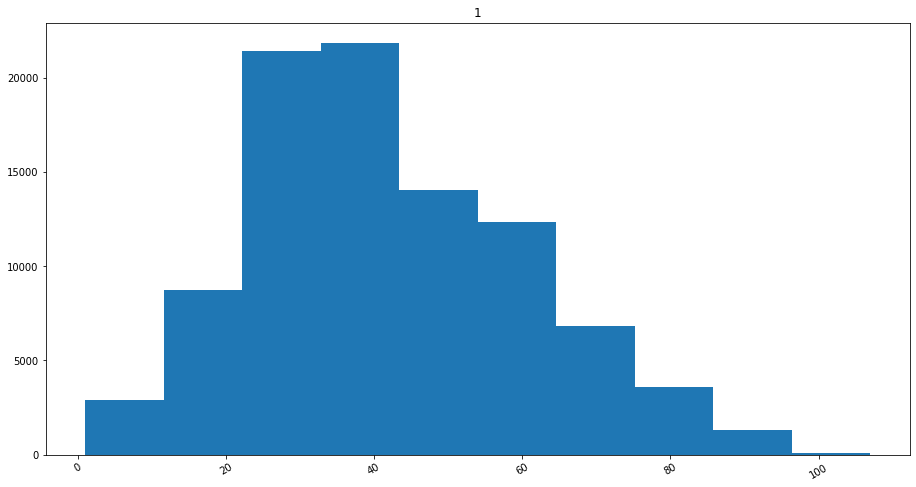

In [ ]:
cifras_min.hist('Edad', 'Numcasos',rot=30, figsize=(15,8))

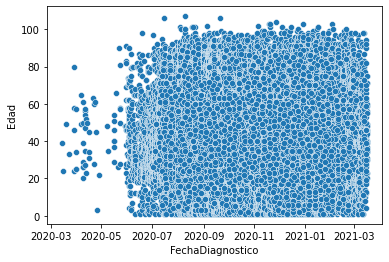

In [ ]:
sns.scatterplot(x='FechaMuerte', y='Edad', data=cifras_min)

In [ ]:
x= 2*10**16/(3600*24)
print(x)

231481481481.48148


In [ ]:
cifras.dtypes

FechaReporte               datetime64[ns]
ID de caso                          int64
id                                  int64
Municipio                          object
Edad                                int64
Sexo                               object
Tipo de contagio                   object
Ubicación del caso                 object
Estado                             object
Nombre del país                    object
Casos                              object
FechaSintomas              datetime64[ns]
FechaMuerte                datetime64[ns]
FechaDiagnostico           datetime64[ns]
FechaRecuperacion          datetime64[ns]
Tipo de recuperación               object
Pertenencia étnica                float64
Nombre del grupo étnico            object
Activos                             int64
Recuperados                         int64
Fallecidos                          int64
Numcasos                            int64
dtype: object

In [ ]:
Sumacasos = cifras.shape[0]

In [ ]:
# Gráfica casos registrados

contagios_registrados = cifras_min.groupby('FechaReporte').sum()
contagios_registrados
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = contagios_registrados.index, y = contagios_registrados['Numcasos'], fill = 'tonexty',
                          line_color = 'orange'))
fig1.update_layout(
    title_text = 'Casos de infección')
fig1.show()

In [ ]:
#Gráfica de los municipios con más fallecidos
diezmas = pd.DataFrame(cifras_min.groupby('Municipio')['Fallecidos'].sum().nlargest(10).sort_values(ascending = False))
fig1 = px.scatter(diezmas, x = diezmas.index, y = 'Fallecidos', size = 'Fallecidos', size_max = 150,
                color = diezmas.index, title = 'Los diez municipios con más muertes')
fig1.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))
fig1.show()

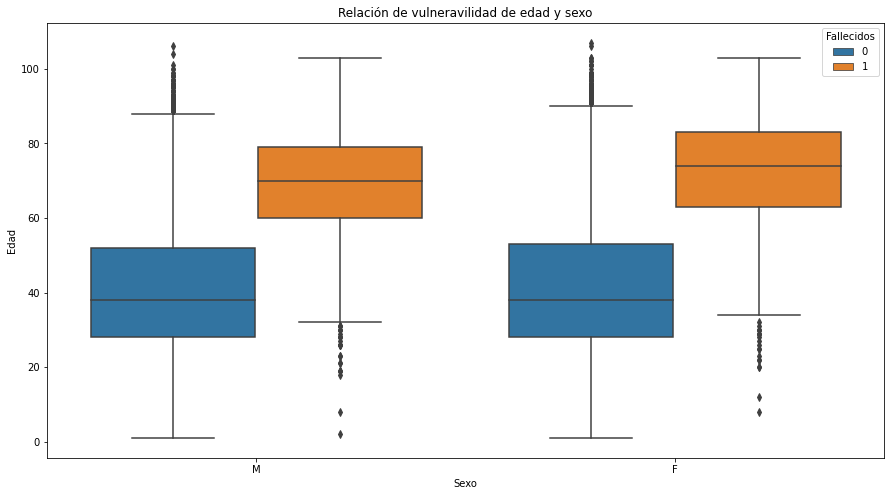

In [ ]:
#Gráfica relación fallecimientos con la edad y el sexo del contagiado
plt.figure(figsize=(15,8))
plt.title('Relación de vulneravilidad de edad y sexo')
sns.boxplot(data=cifras_min, x="Sexo", y='Edad', hue='Fallecidos')

In [ ]:
cifras["Tipo de recuperación"].value_counts()

Tiempo    78336
PCR        9571
Name: Tipo de recuperación, dtype: int64

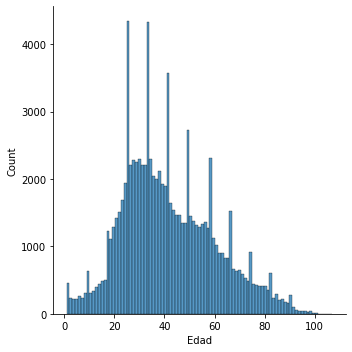

In [ ]:
#Histograma de distribución de la edad
sns.displot(cifras_min['Edad'])

In [ ]:
nom = cifras_min[['id', 'Municipio']]
nom.sort_values('id', inplace=True)
nom = nom.drop_duplicates().reset_index(drop=True)
nom.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,Municipio
0,68001,BUCARAMANGA
1,68013,AGUADA
2,68020,ALBANIA
3,68051,ARATOCA
4,68077,BARBOSA


Desarrollamos el mapa

In [ ]:
#Creamos DataSet especifo para el mapa
mapeo = cifras_min[['Numcasos', 'Municipio','Recuperados','Activos','Fallecidos','Tipo de contagio', 'id']]
mapeo = mapeo.groupby("id", axis=0).sum().reset_index()#Reducimos la extensión del DataFrame Sumando número de casos
mapeo['Municipio']=nom['Municipio']
mapeo.head()

,id,Numcasos,Recuperados,Activos,Fallecidos,Municipio
0,68001,39706,37684,521,1386,BUCARAMANGA
1,68013,10,10,0,0,AGUADA
2,68020,15,15,0,0,ALBANIA
3,68051,138,132,1,3,ARATOCA
4,68077,919,876,14,27,BARBOSA


In [ ]:
with urlopen('https://raw.githubusercontent.com/jadapache/CovidSantander/master/SantanderDpto.geojson') as response:
  santander_map = json.load(response)
  
fig = px.choropleth_mapbox(mapeo, geojson=santander_map, color="Numcasos",
                           locations="id", featureidkey="properties.DPTOMPIO",
                                                      hover_name="Municipio", 
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="open-street-map",
                           zoom=6.5, center = {"lat": 6.836541738999958, "lon": -73.451917132},
                           labels={'Numcasos':'Casos registrados'}
                          )

fig.update_layout(
    title_text = 'Casos de infección en departamento de Santander',
    annotations = [dict(
        x=0.55,
        y=-0.1,
        xref='paper',
        yref='paper',
        text='Fuente: <a href="https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data">\
            Datos Abiertos de Colombia - Casos Positivos COVID-19 </a>',
        showarrow = False
    )]
)

fig.show()